# Predicting the scoring output of NBA players

# Import the data

In [1]:
import pandas as pd
# Read data from CSV. See notebook entitled 'Generate Dataset' to see where this data comes from
data = pd.read_csv('nba_data.csv')

In [2]:
%matplotlib inline
import matplotlib as mpt 
import matplotlib.pyplot as plt 

# Display some histograms
# data.hist(bins=50, figsize=(20,15))
# plt.show()

# Clean up the data

In [3]:
# Drop cases where 2 seasons exist for the same player 
# (bkref stores mid-season trades as 2 seasons, which makes things difficult)
data = data.drop_duplicates(subset=['PLAYER', 'SEASON'])
# Since bkref stores 0s as NaN, replace with 0
data = data.fillna(0)

# Add our target category -- next season's points

In [4]:
# Take a section of the table with Age and points, along with name and for identification
next_yr_pts = data[['AGE', 'PTS', 'PLAYER']]
# Subtract one, so now next season's PTS aligns with this season's AGE
next_yr_pts['AGE'] -= 1

# Merge this data back into the table, using AGE/PLAYER to align
data = pd.merge(next_yr_pts, data, on=['AGE', 'PLAYER'], suffixes=('_NEXT', '_THIS')) 

# Note: Ignore the warning, we want to be working on a copy here

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


# Add new features

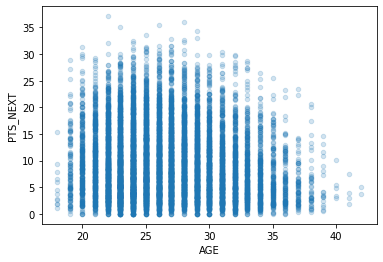

In [5]:
data.plot(kind="scatter", x = "AGE", y = "PTS_NEXT", alpha=0.2)

## Notice how the plot looks roughly parabolic -- we'll add $age^{2}$ as a column

In [6]:
import numpy as np
a2 = np.array(data['AGE'] ** 2)
data.insert(1, 'AGE_SQ', a2)

## We'll also add a column for the percentage of games started 

In [7]:
start_ratio = data['GS'] / data['G']
data.insert(9, 'START_RATIO', start_ratio)

# Split Data into X/Y, and train/val/test

In [8]:
X, y = data.drop(['PTS_NEXT'], axis=1), data['PTS_NEXT']

In [9]:
from sklearn.model_selection import train_test_split 

# The ones with a _df are because we want to keep them as DataFrames, but we turn them into Arrays later
X_train_val, X_test_df, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Finish preparing the data

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Create a Column Transformer to apply to the data 
col_trans = ColumnTransformer([
    # Use onehot encoding for position
    ("pos", OneHotEncoder(), ['POS']), 
    # Standard Scaling for Age/AgeSQ
    ("std", StandardScaler(), ['AGE', 'AGE_SQ']), 
    # Drop the non-numeric columns
    ("drop", "drop", ['SEASON', 'TEAM', 'PLAYER', 'Unnamed: 0'])], 
    remainder="passthrough")

# Apply the column transformers
X_train = col_trans.fit_transform(X_train_df)
X_val = col_trans.transform(X_val_df)
X_test = col_trans.transform(X_test_df)

# Now, let's establish a baseline to compare any models against

In [11]:
from sklearn.metrics import mean_squared_error 

# baseline prediction: assume each player scores the same next season as this season
preds = X_val[:, 32]
mean_squared_error(preds, y_val)

12.818320864505402

 The MSE is 12.818, which any model should beat. First we can try linear regression
 
 ## Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lr_preds = lin_reg.predict(X_val)
mean_squared_error(lr_preds, y_val)

10.981722165208478

Definitely an improvement over the baseline, but there's still room for improvement. Let's try a Random Forest Regressor:

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=256, random_state=42, verbose=2)
rf_reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 256
building tree 2 of 256
building tree 3 of 256
building tree 4 of 256
building tree 5 of 256
building tree 6 of 256
building tree 7 of 256
building tree 8 of 256
building tree 9 of 256
building tree 10 of 256
building tree 11 of 256
building tree 12 of 256
building tree 13 of 256
building tree 14 of 256
building tree 15 of 256
building tree 16 of 256
building tree 17 of 256
building tree 18 of 256
building tree 19 of 256
building tree 20 of 256
building tree 21 of 256
building tree 22 of 256
building tree 23 of 256
building tree 24 of 256
building tree 25 of 256
building tree 26 of 256
building tree 27 of 256
building tree 28 of 256
building tree 29 of 256
building tree 30 of 256
building tree 31 of 256
building tree 32 of 256
building tree 33 of 256
building tree 34 of 256
building tree 35 of 256
building tree 36 of 256
building tree 37 of 256
building tree 38 of 256
building tree 39 of 256
building tree 40 of 256
building tree 41 of 256
building tree 42 of 256
b

[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:   28.5s finished


RandomForestRegressor(n_estimators=256, random_state=42, verbose=2)

In [14]:
rf_preds = rf_reg.predict(X_val)
mean_squared_error(rf_preds, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 256 out of 256 | elapsed:    0.1s finished


11.544442499194865

The Random Forest doesn't give much improvement -- it actually did worse than linear regression on the validation set. Let's try a basic neural network: 

## Neural Network

In [15]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(hidden_layer_sizes=(200, 200, 100), solver='adam', max_iter=350, random_state=42, 
                      learning_rate_init = 1e-4, early_stopping=True)
mlp_reg.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=(200, 200, 100),
             learning_rate_init=0.0001, max_iter=350, random_state=42)

In [16]:
mlp_preds = mlp_reg.predict(X_val)
mean_squared_error(mlp_preds, y_val)

10.876000297860024

The parameters for this MLP were found using grid search. 

In [17]:
# from sklearn.model_selection import GridSearchCV 

# params = {"learning_rate_init": [1e-4, 5e-4, 1e-3, 5e-3, 1e-2], 
#           "learning_rate":["constant", "invscaling", "adaptive"], 
#           "n_iter_no_change": [10, 20, 30]}

# grid = GridSearchCV(mlp_reg, 
#                     params, 
#                     cv=3,
#                     verbose=True, 
#                     scoring="neg_mean_squared_error")

# grid.fit(X_train, y_train)

# Visualizing the results: 
Even with the Neural Net, we're still not getting so accurate. Let's investigate the model's results to see why it didn't work as well as expected

## Performance on Top 50 scorers 
First, let's look at how it performed on the top 50 scorers from last season (2019). Some of these were likely in the training set, so this isn't a perfect indicator, but can still offer insight.

In [18]:
# Get the top 50 scorers last season
top50 = data.loc[data["SEASON"] == "2018-19"].sort_values("PTS_THIS", ascending=False)[:50]

In [19]:
# Find the model's predictions for them
pred_50 = mlp_reg.predict(col_trans.transform(top50.drop("PTS_NEXT", axis=1)))

In [20]:
# Just name and points from top 50
top50_small = top50[["PLAYER", "PTS_THIS", "PTS_NEXT"]]
# Insert the predictions to compare
top50_small.insert(3, "PREDICTED", pred_50)
# Add an accuracy column 
accuracy = top50_small["PREDICTED"] - top50_small["PTS_NEXT"]
top50_small.insert(4, "ACCURACY", accuracy)

# Define a color function to better visualize how the comparison worked 
def color(val): 
    if abs(val) < 1.5:
        col = "#deffe7"
    elif abs(val) < 3: 
        col = "#ffeedb"
    else:
        col = "#ffbaba"
    return 'background-color: %s' % col

top50_small.style.applymap(color, ['ACCURACY'])

,PLAYER,PTS_THIS,PTS_NEXT,PREDICTED,ACCURACY
5263,James Harden,36.1,34.3,32.3765,-1.92348
6240,Paul George,28,21.5,26.219,4.71904
7213,Giannis Antetokounmpo,27.7,29.5,27.68,-1.81996
4748,Joel Embiid,27.5,23,27.4208,4.42078
6719,LeBron James,27.4,25.3,24.5456,-0.754397
4257,Stephen Curry,27.3,20.8,23.5118,2.71179
8607,Devin Booker,26.6,26.6,25.3389,-1.26106
6244,Kawhi Leonard,26.6,27.1,24.7281,-2.3719
6715,Anthony Davis,25.9,26.1,25.3363,-0.763743
9057,Damian Lillard,25.8,30,24.0371,-5.96289


The model looks like it did solidly. Top scorers were often underestimated, but the nature of being a top player means that their scoring is generally more volatile. Let's now look at a sample from the validation set that has a cross section of the entire league

## Performance on league as a whole

In [21]:
# Take 200 seasons from the validation set 
sample = X_val_df[:200][["PLAYER", "SEASON", "PTS_THIS"]]
sample_preds = mlp_reg.predict(X_val[:200])
sample.insert(3, "PREDICTED", sample_preds)
sample.insert(3, "PTS_NEXT", y_val[:200])
accuracy = sample["PREDICTED"] - sample["PTS_NEXT"]
sample.insert(5, "ACCURACY", accuracy)
sample.style.applymap(color, "ACCURACY")

,PLAYER,SEASON,PTS_THIS,PTS_NEXT,PREDICTED,ACCURACY
3587,Rasheed Wallace,2005-06,15.1,12.3,13.0112,0.711214
6510,Brian Shaw,2001-02,2.9,3.5,3.15306,-0.346945
5829,Larry Drew,1985-86,11.9,12.4,10.6664,-1.73361
2663,George Hill,2016-17,16.9,9.4,14.2815,4.88151
5838,Michael Cage,1986-87,15.7,14.5,14.9339,0.4339
9005,Tim Frazier,2014-15,5.7,1.5,9.81601,8.31601
5349,LaSalle Thompson,1987-88,8,12.5,8.81402,-3.68598
12825,Lorenzo Brown,2017-18,2.3,2.1,3.81776,1.71776
4548,Glenn Robinson,2002-03,20.8,16.6,18.0366,1.43664
5221,Ryan Anderson,2016-17,13.6,9.3,12.0262,2.72616


Looking at this more representative sample, the model seems to perform much better. Indeed, if we visualize the performance as a function of points scored, the model seems to overestimate small values and underestimate large values (hence the worse performance in the top 50)

## Accuracy vs Points

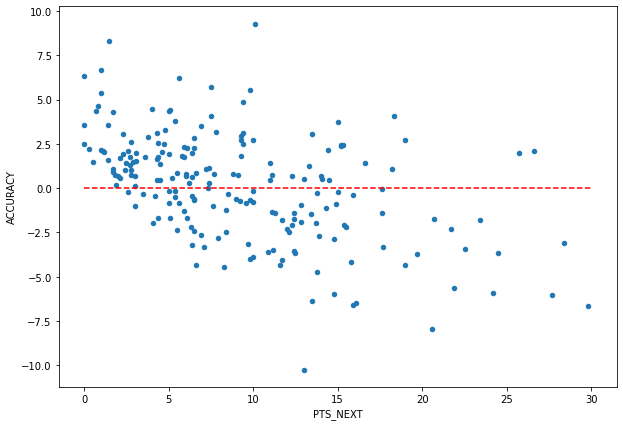

In [22]:
# Plot a scatter of accuracy and points 
sample.plot(x="PTS_NEXT", y="ACCURACY", kind="scatter", figsize=(10,7))
# Plot a line at 0 to better see positive vs negative values
plt.plot([0,30], [0,0], "r--")

We can also look at how the model varies based on the change in points from year to year. Players who had a big jump from one season to the next, i.e. those points above the diagonal, were often severely underestimated. Similarly, those who had a big drop in points were overestimated by the model 

## Accuracy vs Change in Points

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

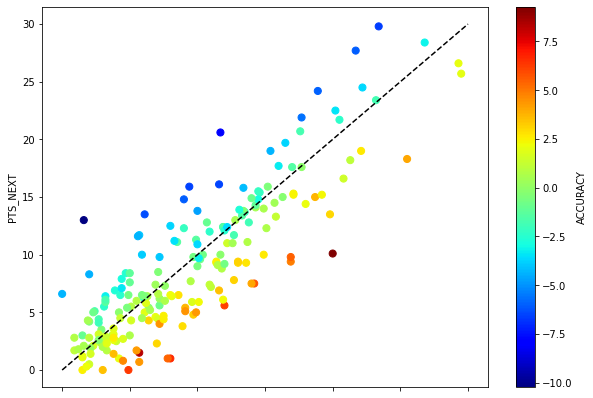

In [23]:
sample.plot(x="PTS_THIS", y="PTS_NEXT", c="ACCURACY", cmap="jet", kind="scatter", figsize=(10,7), 
            s=50)
plt.plot([0,30], [0,30], "k--")

Looking at the results, the model does very well for middle of the road players,  but it doesn't handle exceptions well. In order to improve the model, let's try including more information from the past and use the last 2 seasons' data for each season.

# Add data from 2 seasons ago to the model

In [24]:
# Reload the data. This code is copied from the top of the notebook 
data = pd.read_csv('nba_data.csv')
# Drop cases where 2 seasons exist for the same player 
data = data.drop_duplicates(subset=['PLAYER', 'SEASON'])
# Since bkref stores 0s as NaN, replace with 0
data = data.fillna(0)

# Take a section of the table with Age and points, along with name and for identification
next_yr_pts = data[['AGE', 'PTS', 'PLAYER']]
# Subtract one, so now next season's PTS aligns with this season's AGE
next_yr_pts['AGE'] -= 1

# We also want last year's Minutes Played, Games played, games started, points, and rebounds
last_yr_stats = data[['AGE', 'PLAYER', 'MP', 'G', 'GS', 'PTS']]
last_yr_stats['AGE'] += 1

# Merge this data back into the table, using AGE/PLAYER to align
data = pd.merge(next_yr_pts, data, on=['AGE', 'PLAYER'], suffixes=('_NEXT', '_THIS')) 
data = pd.merge(last_yr_stats, data, on=['AGE', 'PLAYER'], suffixes=('_LAST', '_THIS')) 
# Rename PTS for consistency
data = data.rename(columns={"PTS":"PTS_LAST"})

# Note: Ignore the warning, we want to be working on a copy here

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Same preprocessing steps as last time

In [25]:
a2 = np.array(data['AGE'] ** 2)
data.insert(1, 'AGE_SQ', a2)
start_ratio = data['GS_THIS'] / data['G_THIS']
data.insert(9, 'START_RATIO_THIS', start_ratio)
last_start_ratio = data['GS_LAST'] / data['G_LAST']
data.insert(10, 'START_RAT_LAST', last_start_ratio)

In [26]:
# Split the data up
X, y = data.drop(['PTS_NEXT'], axis=1), data['PTS_NEXT']
X_train_val, X_test_df, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train_df, X_val_df, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Apply the Column transformer
X_train = col_trans.fit_transform(X_train_df)
X_val = col_trans.transform(X_val_df)
X_test = col_trans.transform(X_test_df)

## Linear Regression

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lr_preds = lin_reg.predict(X_val)
mean_squared_error(lr_preds, y_val)

9.44193220463808

We see an improvement of ~1 from last time, so it looks like the added features help.

## Random Forest

In [28]:
rf_reg = RandomForestRegressor(n_estimators=512, random_state=42, verbose=1, max_depth=8)
rf_reg.fit(X_train, y_train)
rf_preds = rf_reg.predict(X_val)
mean_squared_error(rf_preds, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   25.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.1s finished


9.49597839788709

In [29]:
# Let's run a grid search to find the best parameters for the rf 
# params = {"n_estimators": [128, 256, 512], "max_depth":[2, 8, 16]} 

# rf_grid = GridSearchCV(rf_reg, 
#                        params, 
#                        cv=3, 
#                        verbose=3, 
#                        scoring="neg_mean_squared_error")
# rf_grid.fit(X_train, y_train)

The Random Forest didn't give us much improvement over the Linear Regression, but it's much better with the new features. Let's see how the Neural Network does: 

## Neural Network

In [30]:
# NN parameters were found via experimenting with the parameters from last time
mlp_reg = MLPRegressor(hidden_layer_sizes=(200, 200, 200, 100), solver='adam', max_iter=350, random_state=42, 
                      learning_rate_init = 1e-4, early_stopping=True)
mlp_reg.fit(X_train, y_train)
mlp_preds = mlp_reg.predict(X_val)
mean_squared_error(mlp_preds, y_val)

9.703100114316543

# Visualizing the results

## Accuracy vs points

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.0s finished


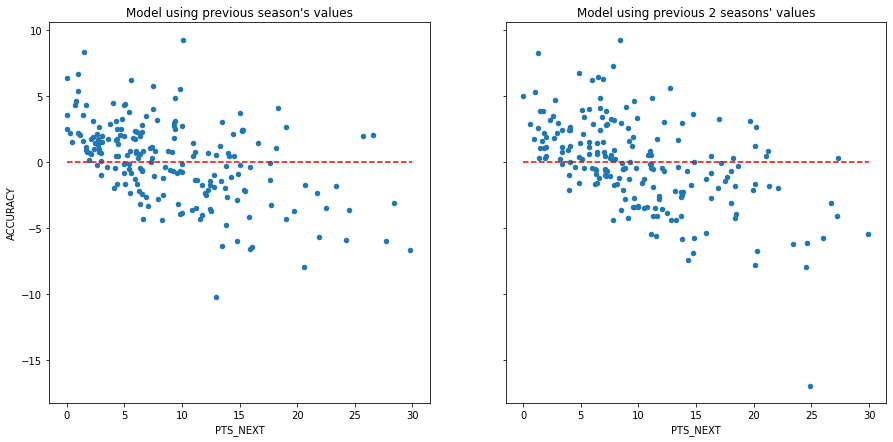

In [31]:
# Take a sample of the val set as we did last time, but with a different name so we can compare them
sample2 = X_val_df[:200][["PLAYER", "SEASON", "PTS_THIS"]]
sample2_preds = rf_reg.predict(X_val[:200])
sample2.insert(3, "PREDICTED", sample2_preds)
sample2.insert(3, "PTS_NEXT", y_val[:200])
accuracy = sample2["PREDICTED"] - sample2["PTS_NEXT"]
sample2.insert(5, "ACCURACY", accuracy)

# Plot a scatter of accuracy and points and compare to the previous one 
fig, subs = plt.subplots(1, 2, sharey=True, figsize=(15,7))
sample.plot(x="PTS_NEXT", y="ACCURACY", kind="scatter", ax=subs[0], 
            title="Model using previous season's values")
sample2.plot(x="PTS_NEXT", y="ACCURACY", kind="scatter", ax=subs[1], 
             title="Model using previous 2 seasons' values")

# Plot a line at 0 to better see positive vs negative values
for sub in subs:
    sub.plot([0,30], [0,0], "r--")


This is an improvement, but it's still isn't working as well as it could -- our MSE is still 9.4. Let's try a totally different approach: Looking at 6 season snapshots of player' careers and using a Recurrent Neural Network for predictions

# Modeling PPG with a Recurrent Neural Network

## Preparing the Data 

In [32]:
# Reload the data again. This code is copied from the top of the notebook 
data = pd.read_csv('nba_data.csv')
# Since bkref stores 0s as NaN, replace with 0
data = data.fillna(0)

To keep things simpler, we're going to use fewer statistics for each player

In [33]:
data = data[["AGE", "PLAYER", "SEASON", "PTS"]]

# Take PTS, name, and AGE. Then, keep adding one to age and merging
old_stats = data[["AGE", "PLAYER", "PTS"]]
for i in range(1, 8): 
    old_stats["AGE"] += 1
    data = pd.merge(old_stats, data, on=["AGE", "PLAYER"], suffixes=("_" + str(i) + "AGO", "")) 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# Some duplication occured, so we need to drop duplicates again 
data = data.drop_duplicates(subset=["SEASON", "PLAYER"])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3884 entries, 0 to 11300
Data columns (total 11 columns):
AGE         3884 non-null int64
PLAYER      3884 non-null object
PTS_7AGO    3884 non-null float64
PTS_6AGO    3884 non-null float64
PTS_5AGO    3884 non-null float64
PTS_4AGO    3884 non-null float64
PTS_3AGO    3884 non-null float64
PTS_2AGO    3884 non-null float64
PTS_1AGO    3884 non-null float64
SEASON      3884 non-null object
PTS         3884 non-null float64
dtypes: float64(8), int64(1), object(2)
memory usage: 364.1+ KB


Now we essentially have a time series -- for each season, we have the PPG data for the 6 seasons before it. Now let's finish the preparations so we can train the model

## Split into train/test

In [35]:
import numpy as np
X, y = np.array(data.drop(["AGE", "PLAYER", "SEASON", "PTS"], axis=1)), np.array(data["PTS"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=0)

# Add a dimension to make them the right shape
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]
y_test = y_test[..., np.newaxis]

# Build a Recurrent Neural Network

We're using GRUs in this network, which is a special layer for RNNs

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam 

tf.random.set_seed(42)
keras.backend.clear_session()

# Create the model 
model = Sequential([ 
    GRU(32),
    Dense(1)
])

# Early stopping callback 
estop = EarlyStopping(patience=50, restore_best_weights=True)

opt = Adam(lr=0.001)
model.compile(loss="mse", optimizer=opt)
hist = model.fit(X_train, y_train, epochs=500, 
                 validation_split=0.1, 
                 callbacks=[estop])

Epoch 1/500
99/99 [==============================] - 1s 5ms/step - loss: 88.3216 - val_loss: 51.2533
Epoch 2/500
99/99 [==============================] - 0s 2ms/step - loss: 38.3616 - val_loss: 30.9564
Epoch 3/500
99/99 [==============================] - 0s 3ms/step - loss: 25.3016 - val_loss: 22.5928
Epoch 4/500
99/99 [==============================] - 0s 3ms/step - loss: 19.4663 - val_loss: 18.0548
Epoch 5/500
99/99 [==============================] - 0s 2ms/step - loss: 16.2788 - val_loss: 15.1439
Epoch 6/500
99/99 [==============================] - 0s 2ms/step - loss: 14.1626 - val_loss: 13.2465
Epoch 7/500
99/99 [==============================] - 0s 2ms/step - loss: 12.7958 - val_loss: 11.9699
Epoch 8/500
99/99 [==============================] - 0s 3ms/step - loss: 11.8471 - val_loss: 11.1440
Epoch 9/500
99/99 [==============================] - 0s 2ms/step - loss: 11.1846 - val_loss: 10.6183
Epoch 10/500
99/99 [==============================] - 0s 2ms/step - loss: 10.6879 - val_los

Epoch 83/500
99/99 [==============================] - 0s 3ms/step - loss: 8.2910 - val_loss: 8.4205
Epoch 84/500
99/99 [==============================] - 0s 3ms/step - loss: 8.2862 - val_loss: 8.5215
Epoch 85/500
99/99 [==============================] - 0s 2ms/step - loss: 8.2808 - val_loss: 8.4667
Epoch 86/500
99/99 [==============================] - 0s 3ms/step - loss: 8.2421 - val_loss: 8.3607
Epoch 87/500
99/99 [==============================] - 0s 3ms/step - loss: 8.2588 - val_loss: 8.4310
Epoch 88/500
99/99 [==============================] - 0s 2ms/step - loss: 8.2860 - val_loss: 8.3238
Epoch 89/500
99/99 [==============================] - 0s 2ms/step - loss: 8.2210 - val_loss: 8.4342
Epoch 90/500
99/99 [==============================] - 0s 2ms/step - loss: 8.3112 - val_loss: 8.3355


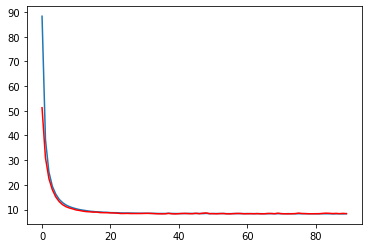

In [37]:
# Plot the learning curve

plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"], "r")

In [38]:
mean_squared_error(model.predict(X_test), y_test)

8.881880068334981

It took much experimenting to find optimal parameters, but in the end, the best architecture for the RNN was just one layer of GRUs, with a small Dense layer serving as output. This simple network actually worked quite well -- we got an accuracy of 8.88 on the test set, which is still not amazing, but is significantly better than any of the previous attempts. We can also visualize how this model differed from the previous ones: 

# Visualizing performance of the Network

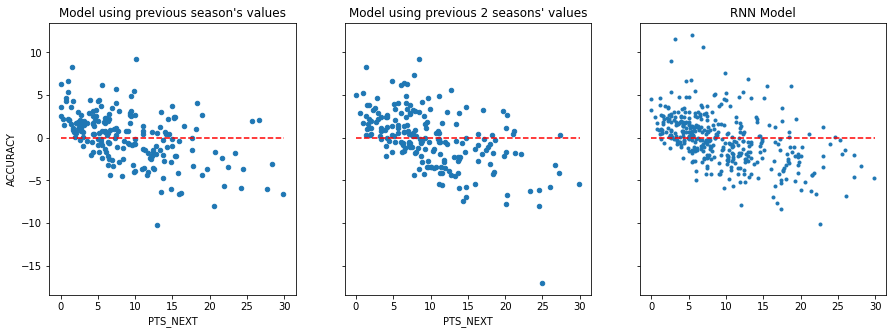

In [39]:
# Get the accuracy
preds = model.predict(X_test[:, :200, :])
accuracy = preds - y_test[:, :200]

# Create a subplot 
fig, subs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
sample.plot(x="PTS_NEXT", y="ACCURACY", kind="scatter", ax=subs[0], 
            title="Model using previous season's values")
sample2.plot(x="PTS_NEXT", y="ACCURACY", kind="scatter", ax=subs[1], 
             title="Model using previous 2 seasons' values")
subs[2].plot(y_test, accuracy, ".")
subs[2].set_title("RNN Model")

# Plot a line at 0 to better see positive vs negative values
for sub in subs:
    sub.plot([0,30], [0,0], "r--")

This network has the same problem as the others, where it overestimates small vaues and underestimates large values. Let's take a look at the actual series it was estimating on to see why this error occured

## What kinds of series did the network fail on?

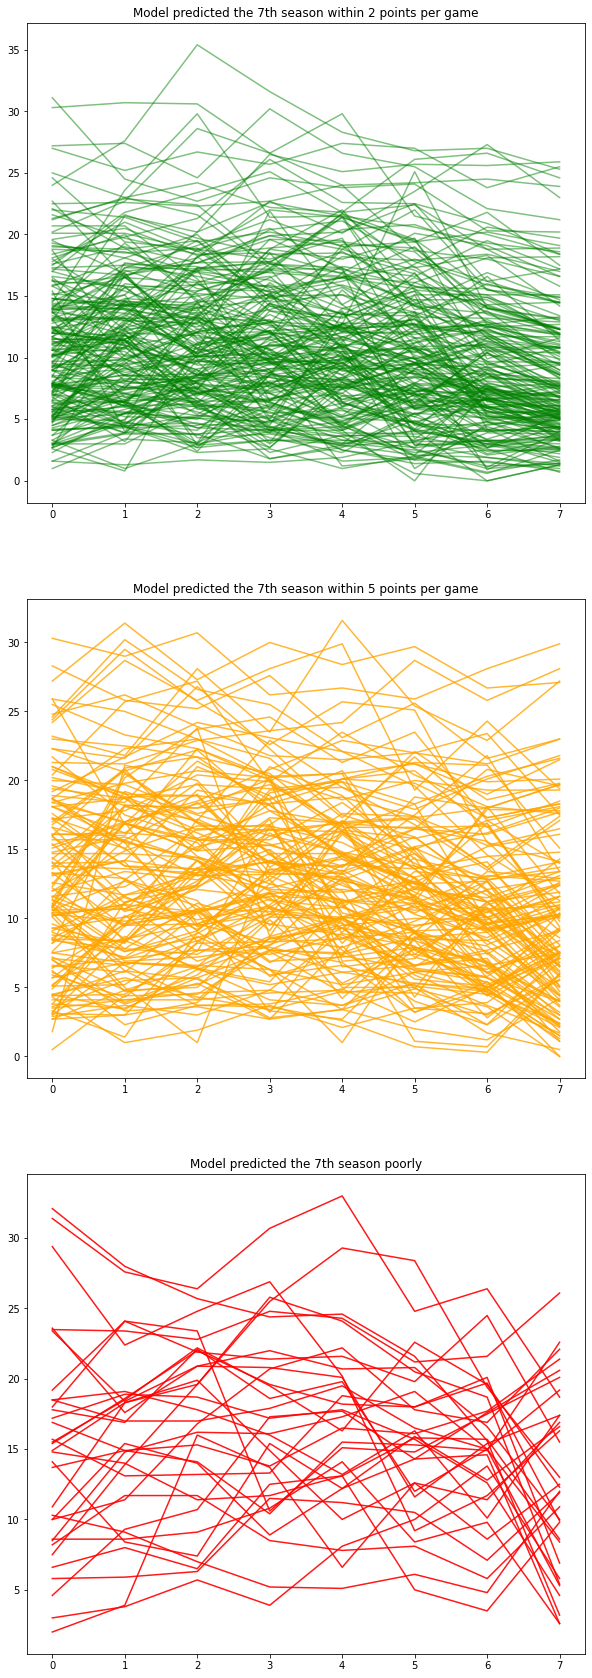

In [40]:
# Concatenate X and y to get a list of all the series of points 
tot_series = np.c_[X_test[:,:,0], y_test[:, 0]]

# Create a figure with 3 subplots
fig, (sub1, sub2, sub3) = plt.subplots(3,1, figsize=(10, 30))

# Set titles
sub1.set_title("Model predicted the 7th season within 2 points per game")
sub2.set_title("Model predicted the 7th season within 5 points per game")
sub3.set_title("Model predicted the 7th season poorly")

# We now want the absolute value of accuracy
abs_acc = np.abs(accuracy) 

for (i, series) in enumerate(tot_series): 
    # Plot based on how accurate the model was on a given series
    if abs_acc[i] < 2:
        sub1.plot(series, color="green", alpha=0.5)
    elif abs_acc[i] < 5:
        sub2.plot(series, color="orange", alpha=0.8)
    else:
        sub3.plot(series, color="red", alpha=.9)

Looking at these graphs, it's clear what the problem is. The graphs in red (where the model performed poorly) have big jumps at the end, which the model didn't anticipate. The graphs in orange all have smaller jumps, and the graphs in green all have small or no jumps. Considering the nature of the NBA, this makes sense -- plenty of seasons are derailed by injuries, and many players make sudden leaps after being given more playing time. As much as it's possible to predict scoring, there will always be these outliers that defy prediction. For example, consider the graph on which the model had the worst performance:

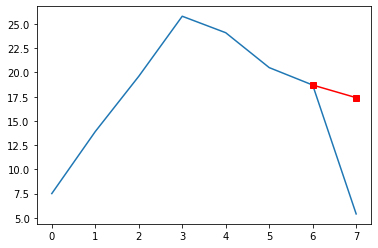

In [41]:
# Get the model's prediction for that had the worst accuracy 
worst_index = np.argmax(abs_acc)
worst = tot_series[worst_index]
plt.plot(worst)
plt.plot([6, 7], [worst[6], preds[worst_index]], "rs-")

The model predicted a gradual decline, but the player's performance instead fell off a cliff. Indeed, this graph belongs to Danny Granger, who suffered knee injuries during the 2012-13 season, playing only 5 games and scoring only 5.4 PPG. Without foreknowledge of injuries, there's no way our model could have forecast this drop in performance. 

# Conclusion

Though Machine Learning can provide solid models to predict the scoring of NBA players, it has limitations. The first approach just used the previous season's statistics, and despite scoring better than our baseline, it's predictions were still relatively inaccurate. The model performed better when it was able to incorporate data from the previous 2 seasons, reaching an MSE of 9.44, but even then there was still room for improvement. Changing our approach completely, the Recurrent Neural Network worked much better. Though it still wasn't perfect (Error of 8.88 on the test set), we saw that many of the mistakes it made were caused by players behaving unpredictably. At the end of the day, the scoring output of an NBA player is affecting strongly by factors like injuries and sudden breakouts which no model can predict. Despite these fundamental limitations, though, the Recurrent Neural Network was still able to successfully make predictions. 

# Bonus: Predictions for next season

In [42]:
# Reload the data again. This code is copied from the top of the notebook 
data = pd.read_csv('nba_data.csv')
# Since bkref stores 0s as NaN, replace with 0
data = data.fillna(0)

data = data[["AGE", "PLAYER", "SEASON", "PTS"]]

# Take PTS, name, and AGE. Then, keep adding one to age and merging
old_stats = data[["AGE", "PLAYER", "PTS"]]

# We're only using data from the past 4. The predictions are only slightly worse, 
# but it includes more players
for i in range(1, 4): 
    old_stats["AGE"] += 1
    data = pd.merge(old_stats, data, on=["AGE", "PLAYER"], suffixes=("_" + str(i) + "AGO", "")) 
    
data = data.drop_duplicates(subset=["SEASON", "PLAYER"])   
# Get the data for this season
this_season = data.loc[data["SEASON"] == "2019-20"]
# We only want the points from the past 6 seasons to feed into the model 
this_points = np.array(this_season.drop(["AGE", "PLAYER", "SEASON"], axis=1))
# Add a dimension for the NN
this_points = this_points[..., np.newaxis]
# Get the predictions 
next_points = model.predict(this_points)

# Insert the results back into the DataFrame
this_season.insert(2, "PTS_PREDICTED", next_points)
# Just take player, this season's points, and predicted points
next_season = this_season[["PLAYER", "PTS", "PTS_PREDICTED"]]
# Set it so Pandas displays the entire DataFrame
pd.set_option("display.max_rows", None)
next_season.sort_values("PTS_PREDICTED", ascending=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,PLAYER,PTS,PTS_PREDICTED
11495,Bradley Beal,30.5,25.352047
9811,Damian Lillard,30.0,25.338036
7894,Giannis Antetokounmpo,29.5,25.315037
6042,James Harden,34.3,25.257635
3166,Kyrie Irving,27.4,25.132973
10706,Kawhi Leonard,27.1,25.108145
8817,Russell Westbrook,27.2,25.094765
9303,Devin Booker,26.6,25.047483
12543,Karl-Anthony Towns,26.5,24.998316
13514,Anthony Davis,26.1,24.955940


The values for the top players are a bit deflated, because no model handles outliers well. Otherwise, we'll have to see next year how this model does. -- Michael Gul, 9/1/2020